In [1]:
import os
import numpy as np
import random
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
%load_ext autoreload
%autoreload 2

In [2]:
from models import *
from data_handlers import *
from utilities import *

In [3]:
RANDOM_SEED = 227

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [4]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok= True)
dataset = Planetoid(root=data_dir, name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [5]:
print_basic_info(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = GCN(hidden_channels=16)
model = GAT(num_features=dataset.num_features, hidden_channels=8,num_classes=dataset.num_classes)
print(model)
model = model.to(device)
data = data.to(device)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [7]:
# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters()
                             ,lr = learning_rate,
                             weight_decay= decay)

In [8]:
# Loss Function
criterion = torch.nn.CrossEntropyLoss()

In [9]:
torch.sum(data.test_mask)

tensor(1000, device='cuda:0')

In [10]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


In [11]:
def validate(model, data):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)
	correct = pred[data.val_mask] == data.y[data.val_mask]
	acc = int(correct.sum()) / int(data.val_mask.sum())
	return acc

In [12]:
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc

In [13]:
os.makedirs('checkpoints', exist_ok=True)
losses = []
best_val_acc = 0
best_epoch = 0
for epoch in range(0, 1001):
    loss = train(model, data, optimizer, criterion)
    losses.append(loss)
    val_acc = validate(model, data)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'checkpoints/best_model.pth')
    if epoch % 100 == 0:
        print(f'Epoch:{epoch:03d}, Loss:{loss:.4f}')

Epoch:000, Loss:1.9464
Epoch:100, Loss:0.4781
Epoch:200, Loss:0.5200
Epoch:300, Loss:0.4526
Epoch:400, Loss:0.5489
Epoch:500, Loss:0.4911
Epoch:600, Loss:0.4169
Epoch:700, Loss:0.4024
Epoch:800, Loss:0.4190
Epoch:900, Loss:0.5194
Epoch:1000, Loss:0.4179


In [14]:
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
test(model, data)

0.827

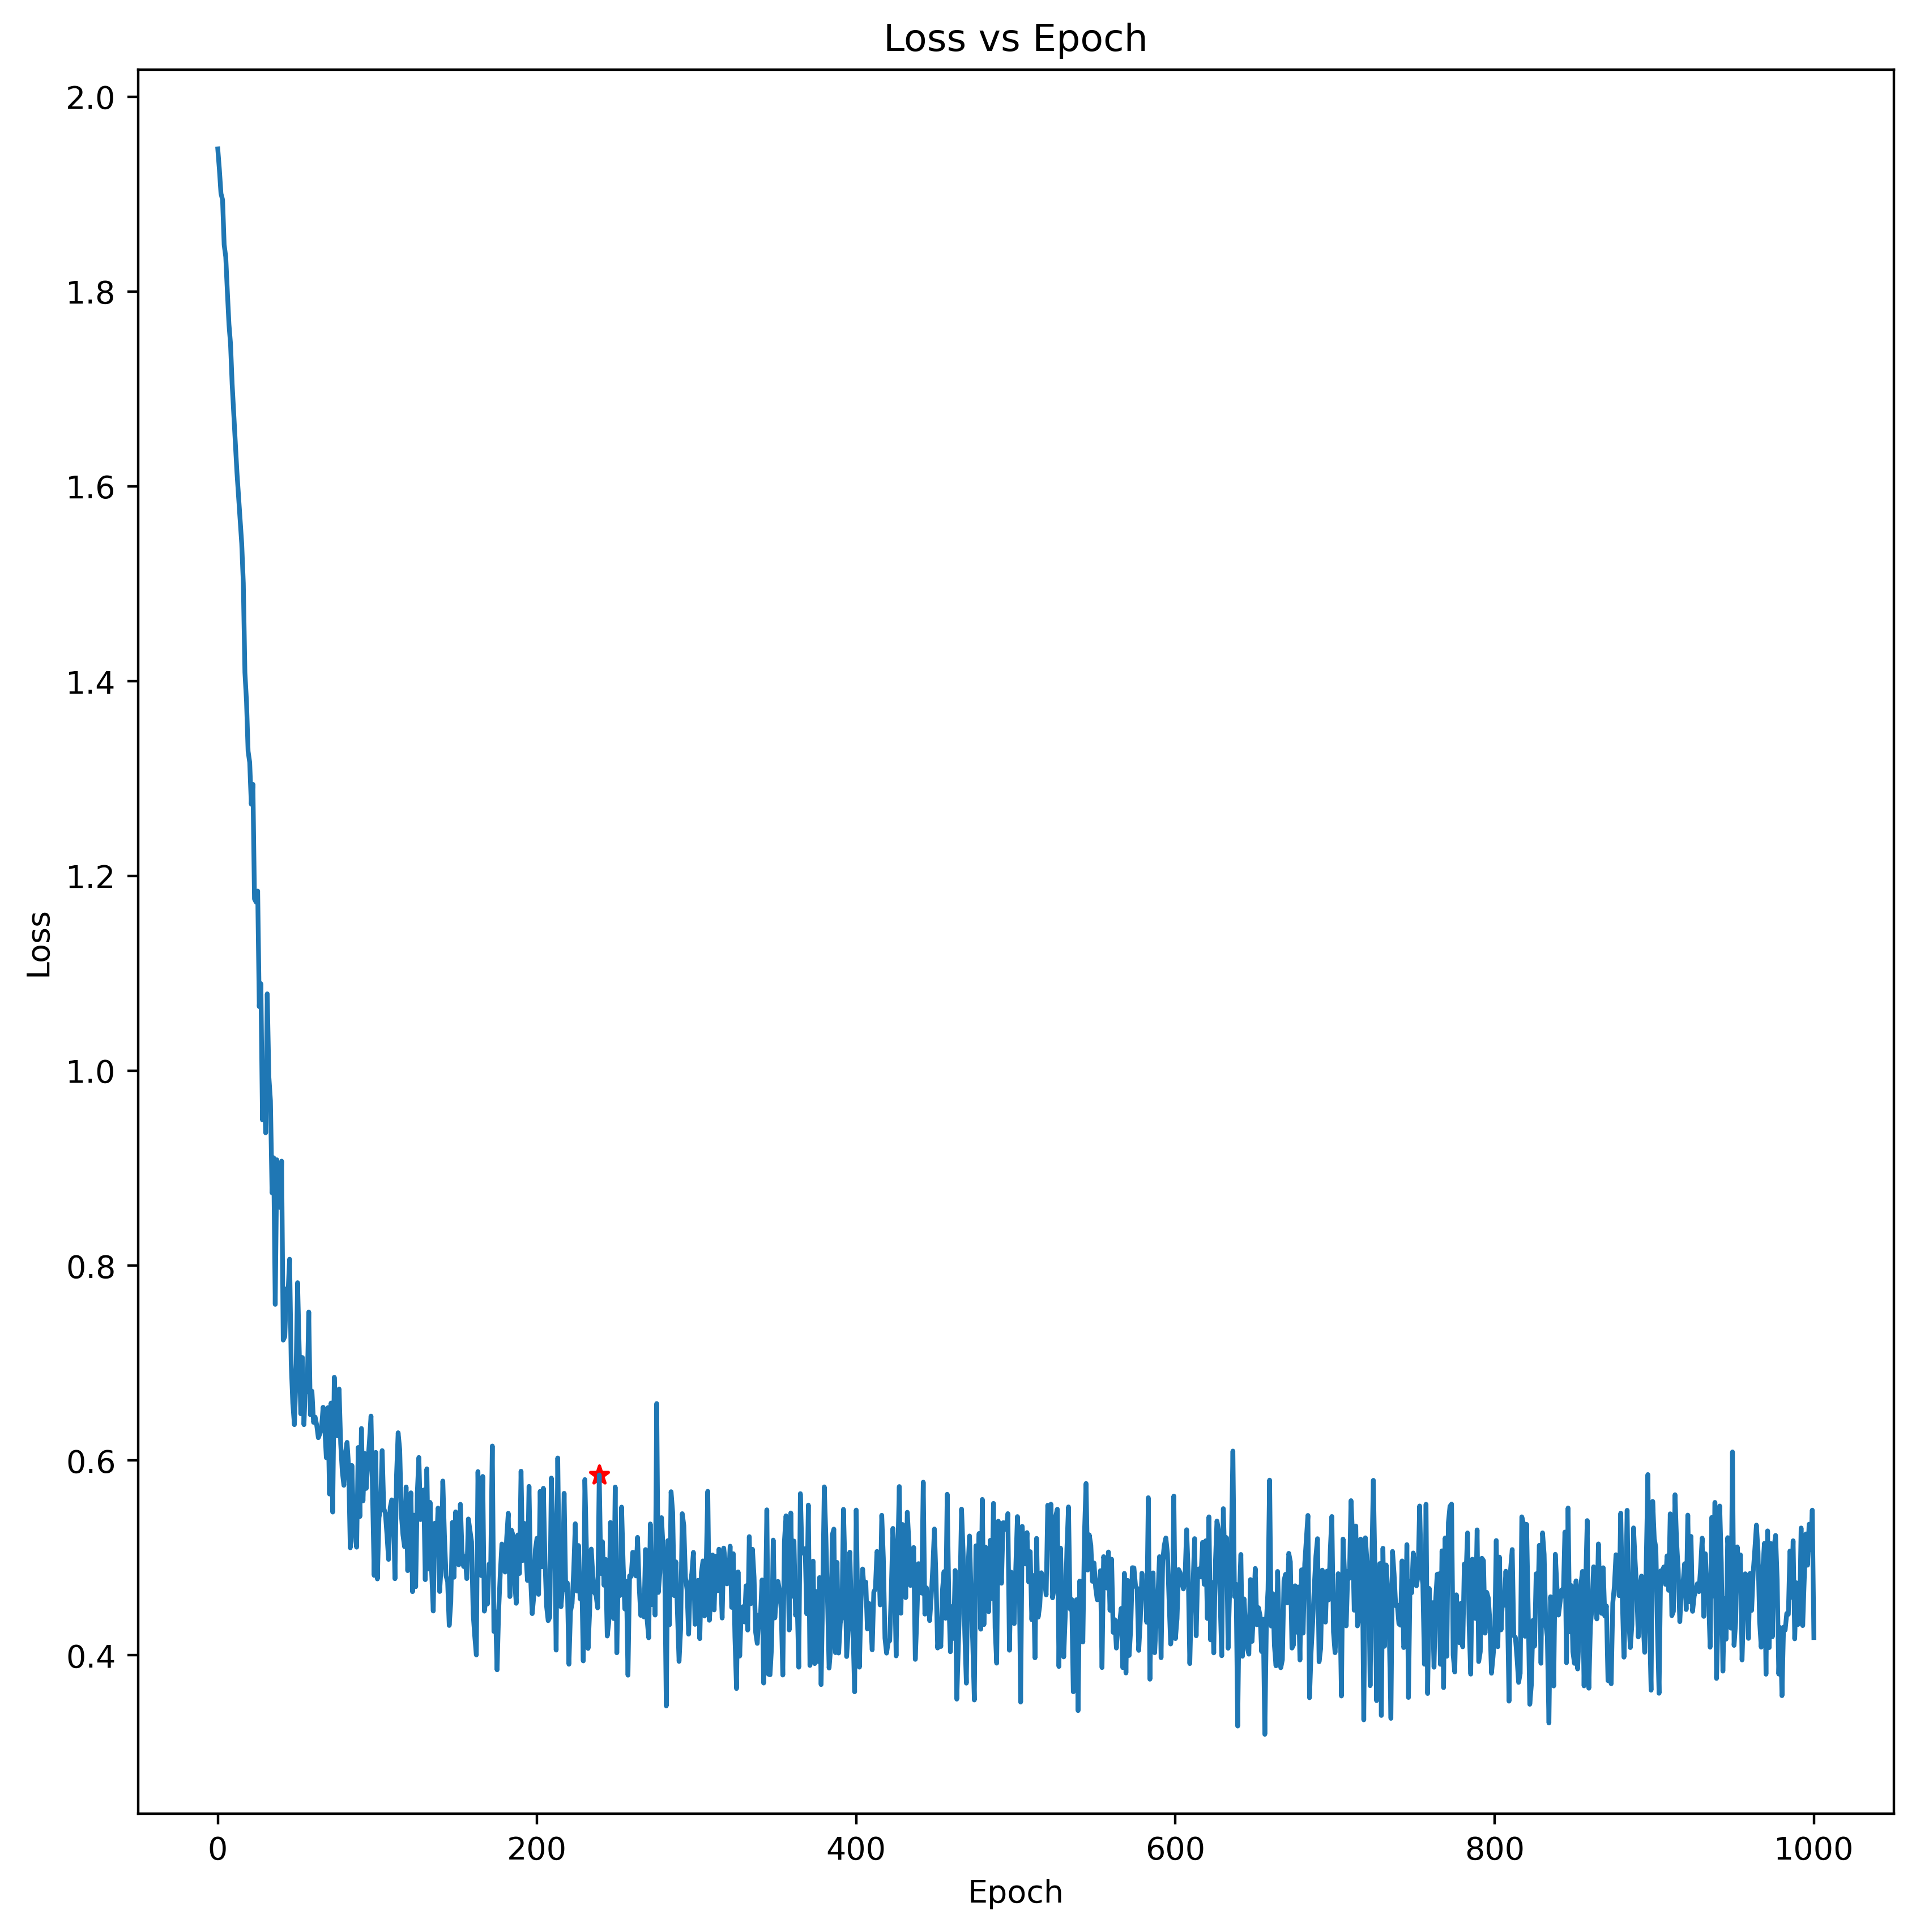

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt.figure(figsize=(10,10), dpi=400)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.plot(loss_indices, losses_float)
plt.scatter(best_epoch, losses_float[best_epoch], c='r', label="Best Epoch", marker='*')

In [17]:
test_acc = test(model, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8270


In [ ]:
# Converting mask to index
train_index = np.array([i for i, x in enumerate(data.train_mask) if x])
test_index = np.array( [i for i, x in enumerate(data.test_mask) if x])